# Hälsodataanalys

**Irene Grisenti**  
**28/11/2025**  

Detta projekt innehåller en analys av hälsodata med fokus på rökning, blodtryck och [...].

I den första delen laddar jag in datasetet och genomför en initial utforskning.
Målet är att förstå datastrukturen, kontrollera om det finns saknade värden eller dubbletter samt ta fram grundläggande beskrivande statistik.
Denna förberedelse säkerställer att data är redo för vidare analys och visualiseringar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from src.analyzer import *
from src.stats_tests import *

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
plt.style.use("ggplot")

In [2]:
# Läsning av datasetet
df = pd.read_csv("data/health_study_dataset.csv")

# Skapa ett HealthAnalyzer-objekt
analyzer = HealthAnalyzer(df)

# Utforska datasetet
analyzer.explore()

# Städning
analyzer.cleaning()

Data sample:
      id  age sex  height  weight  systolic_bp  cholesterol smoker  disease
220  221   84   F   147.1    65.8        168.6         6.16    Yes        0
164  165   64   F   167.7    72.5        164.9         5.65     No        1
635  636   25   M   175.9    86.9        151.1         4.27     No        0
206  207   57   F   156.7    66.3        149.6         5.13     No        0
559  560   43   F   166.7    73.4        155.7         4.83     No        0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 


### Inledande observation

- Datasetet innehåller 800 rader, 9 kolumner. Inga saknade värden eller dubbletter

- Datatyper: 
    - Numeriska kontinuerliga: height, weight, systolic_bp, cholesterol
    - Numeriska diskreta: id, age, disease
    - Kategoriska: sex, smoker

- Range och fördelning:
    - Ålder varierar mellan 18 och 90 år, med ett medelvärde på cirka 49 år
    - Längd och vikt ligger inom rimliga intervall för vuxna
    - Blodtryck och kolesterol har också sannolika värden

## Beskrivande analys

I detta steg utför jag en beskrivande analys av datasetet för att bättre förstå vår population och dess hälsomått.  
Jag tittar på centrala tendenser (medelvärde, median, min och max) och visualiserar olika aspekter av datan för att identifiera mönster och relationer mellan variabler.

- Beräkning av medelvärde, median, min och max för age, weight, height, systolic_bp och cholesterol.
- Visualizing:
    - Population overview: 
        - Age distribution by gender
        - Percentage of smokers vs non-smokers
    - Health metrics:
        - BMI distribution
        - Cholesterol levels by gender
    - Relationships:
        - Age vs Cholesterol
        - Systolic BP for people with/without disease

### Insikter:
1. Män och kvinnor är ganska jämnt representerade över åldersspektrumet och förekomsten av rökare är låg.
2. Normal viktintervall med få extremvärden. Liknande kolesterolnivåer mellan kvinnor och män.
3. Scatter-diagrammet visar att kolesterolnivån tenderar att öka med åldern. 
4. Det systoliska blodtrycket är liknande mellan grupper med eller utan sjukdom, vilket tyder på att det systoliska blodtrycket ensam inte kan indikera en grupp med eller utan sjukdom.

In [3]:
specific_stats = analyzer.compute_stats(["age","weight","height"])
print(specific_stats)

           age   weight   height
mean    49.426   73.413  171.849
median  50.000   73.200  171.350
min     18.000   33.700  144.400
max     90.000  114.400  200.400


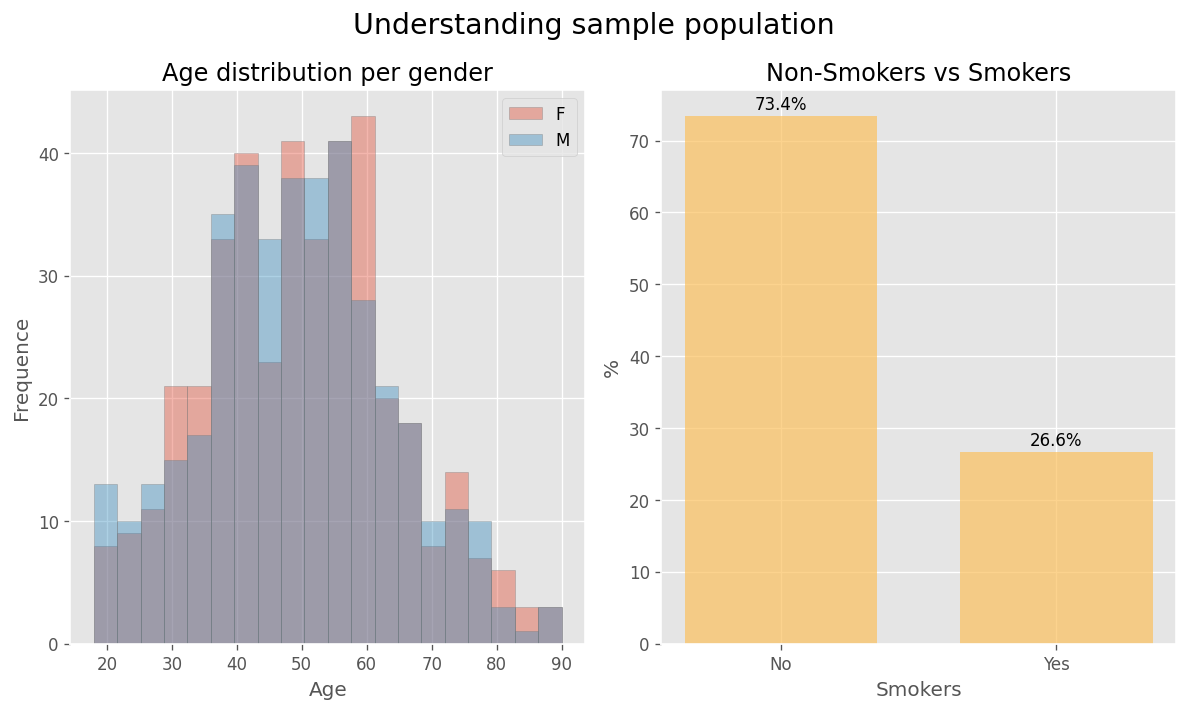

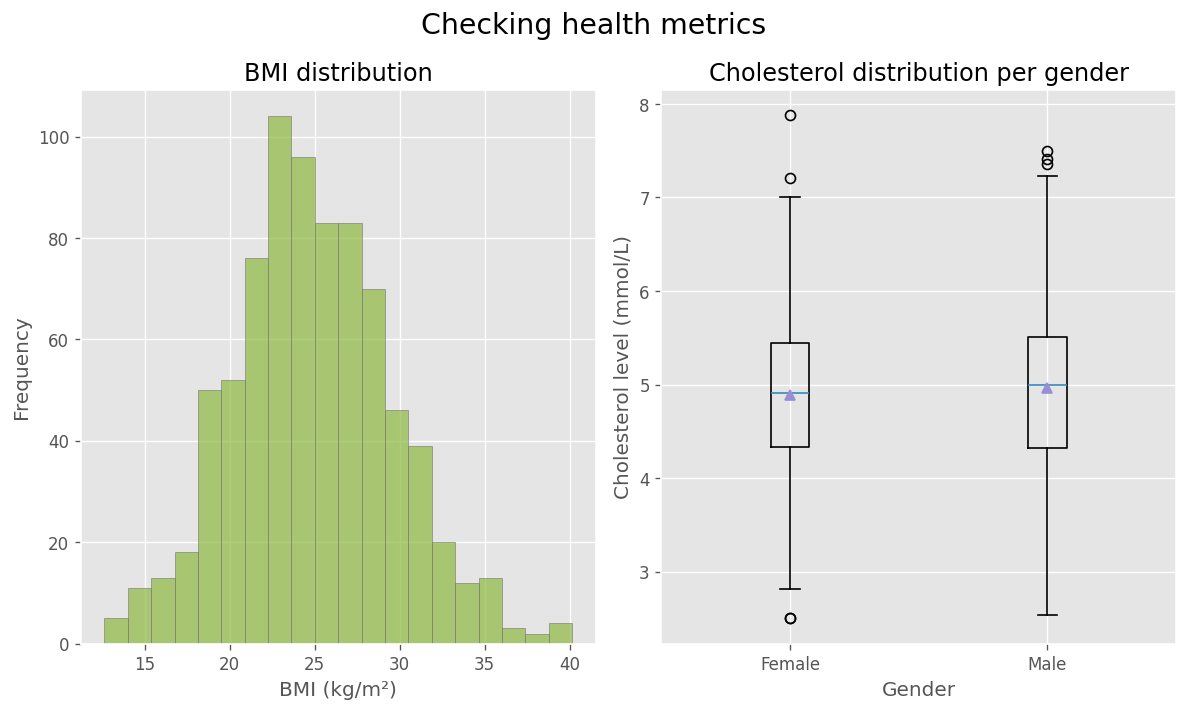

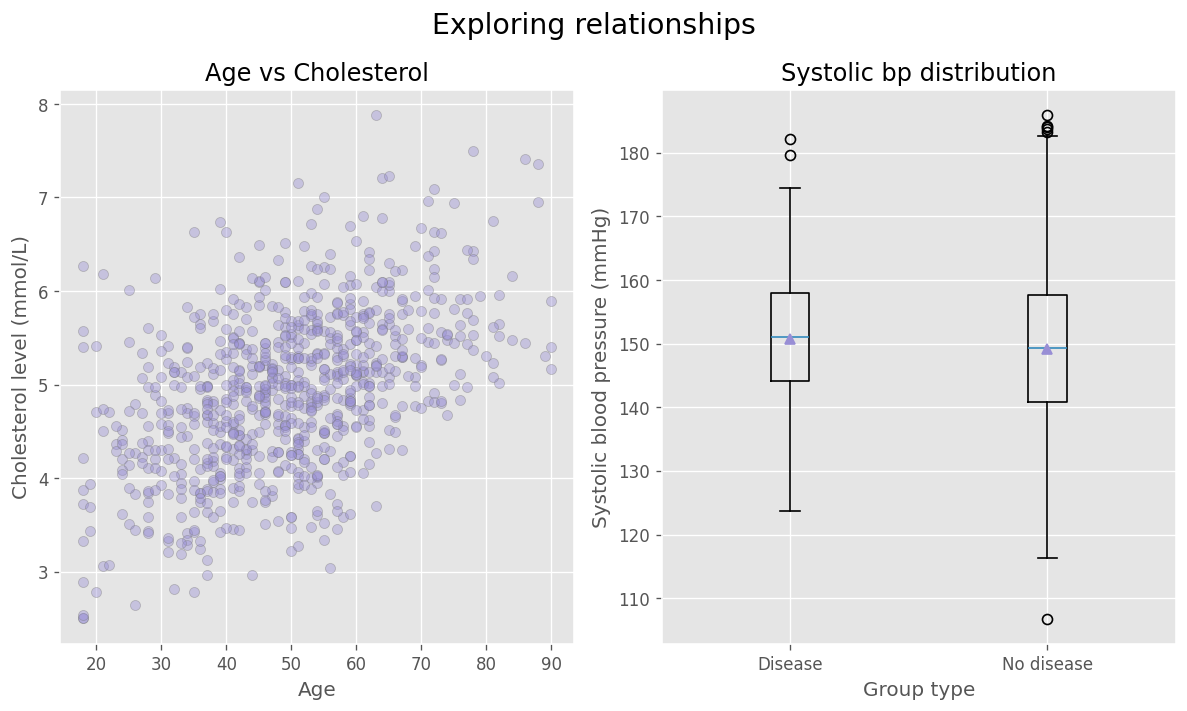

In [4]:
analyzer.plot_population_overview("img/fig1")
analyzer.plot_health_metrics("img/fig2")
analyzer.plot_relationships("img/fig3")

## Simulering kopplad till caset

I detta steg simulerar jag sjukdomsförekomst i en population med samma prevalens som i vårt dataset.  
Syftet är att jämföra den simulerade sjukdomsfrekvensen med den verkliga frekvensen i datan och se hur mycket slumpen kan påverka resultaten.  

Genom simuleringen kan vi:
- Förstå variationen i sjukdomsförekomst vid upprepade slumpmässiga urval.  
- Kontrollera om datasetets sjukdomsfrekvens ligger inom det förväntade intervallet.

**Slutsats**:
Skillnaden mellan den verkliga sjukdomsfrekvensen och den simulerade sjukdomsfrekvensen
är liten och ligger inom den förväntade variationen.

In [5]:
analyzer.simulation_disease(n=1000, seed=42)

{'Verklig förekomst': np.float64(5.875),
 'simulerad förekomst': np.float64(5.4),
 'skillnad': np.float64(-0.47)}

## Konfidensintervall

I detta steg uppskattar vi 95% konfidensintervall för systoliskt blodtryck med två metoder:

1. **Normal Approximation** – antar att medelvärdet för urvalet är ungefär normalt fördelat.
2. **Bootstrap** – en resampling-metod som inte gör antaganden om fördelningen.

Syftet är att:
- Visa osäkerheten i vårt uppskattade medelvärde.  
- Jämföra resultaten från en analytisk metod (normalapproximation) med en mer flexibel, data-driven metod (bootstrap).  
- Bedöma om normalapproximationen är rimlig för detta dataset.

**Slutsats:**  
Båda metoderna ger mycket liknande resultat, vilket tyder på att normalapproximationen är rimlig och att samplingfördelningen för medelvärdet är nära normal.

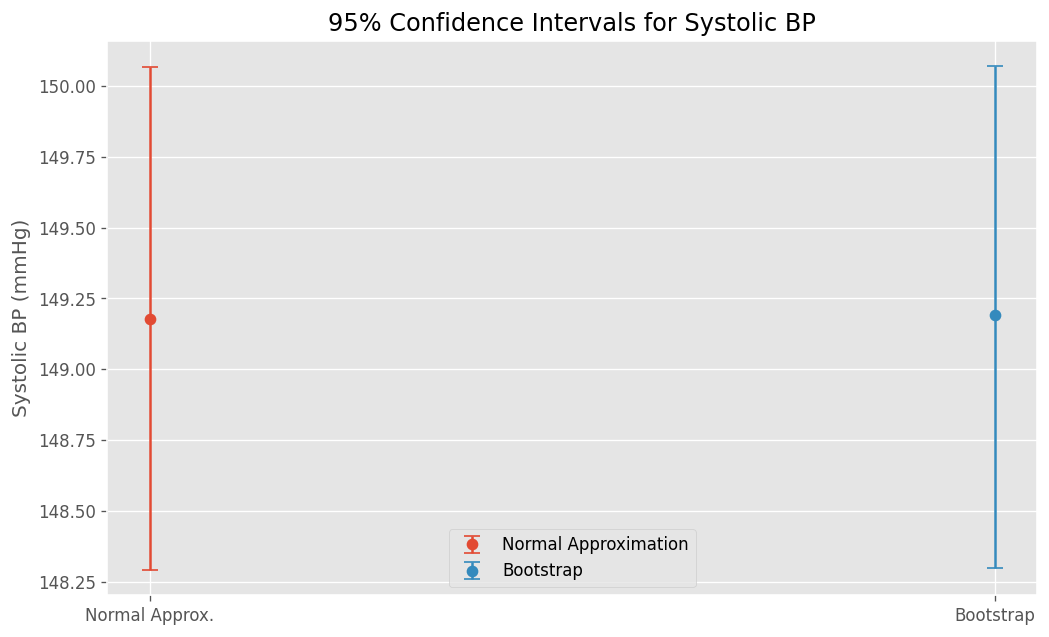

Punktuppskattning                     : 149.18
Standardavvikelse                     : 12.79

Resultatet av normalapproximationen är: 148.29 - 150.07

Resultatet från bootstrap är          : 148.30 - 150.07
Medelvärde för statistiken            : 149.19




{'Punktuppskattning': np.float64(149.178625),
 'Standardavvikelse': np.float64(12.793360316766597),
 'Resultatet av normalapproximationen är': (np.float64(148.29209036025347),
  np.float64(150.06515963974655)),
 'Resultatet från bootstrap är': (np.float64(148.29824687499996),
  np.float64(150.06938125000002)),
 'Medelvärde för statistiken': np.float64(149.191138125)}

In [6]:
analyzer.plot_systolic_bp_confidence_intervals(seed=42)

## Hypotesprövning

I detta steg testar vi om rökare har högre systoliskt blodtryck än icke-rökare. Syftet är att bedöma om den observerade skillnaden i blodtryck är så stor att den inte rimligen kan förklaras av slumpen.  

**Hypoteser**:  
H0: Rökare och icke-rökare har samma blodtryck *(mean_smokers = mean_non_smokers)*  
H1: Rökare har högre blodtryck än icke-rökare *(mean_smokers > mean_non_smokers)*

**Motivering och val av test**:  
Val av test: Tvåprovstest (Welch’s t-test)
- Data är kvantitativa och de två grupperna är oberoende.
- Welch’s t-test är lämpligt eftersom grupperna har olika storlekar.
- Ensidigt test (höger svans) används eftersom vi specifikt vill testa om rökare har högre blodtryck.
- Signifikansnivå α = 0,05, vilket är standard.

**Tolkning**:
Eftersom p-värdet är större än 0,05 kan vi inte förkasta H0. Det finns inte tillräckligt med bevis för att dra slutsatsen att rökare har högre blodtryck än icke-rökare.

In [13]:
# Parameters
smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

n_smokers, n_non_smokers = len(smokers), len(non_smokers)
smokers_mean, non_smokers_mean = smokers.mean(), non_smokers.mean()
sd_smokers, sd_non_smokers = smokers.std(), non_smokers.std()

diff_means = smokers_mean - non_smokers_mean

# Statistical tests
ttest_smokers_nonsmokers = ttest_smokers_vs_non_smokers(smokers, non_smokers)
t_stat, p_val, mean_diff = ttest_smokers_nonsmokers
effect = effect_calculation(smokers, non_smokers)

summary1 = pd.DataFrame({
    "Metric": [
        "n (smokers)", "n (non-smokers)",
        "Mean smokers", "Mean non-smokers",
        "SD smokers", "SD non-smokers",
        "Mean difference",
        "T-statistic", "P-value"
    ],
    "Value": [
        n_smokers, n_non_smokers,
        f"{smokers_mean:.2f}", f"{non_smokers_mean:.2f}",
        f"{sd_smokers:.2f}", f"{sd_non_smokers:.2f}",
        f"{diff_means:.2f}",
        f"{t_stat:.3f}", f"{p_val:.4f}"
    ]
})

summary1

,Metric,Value
0,n (smokers),213
1,n (non-smokers),587
2,Mean smokers,149.52
3,Mean non-smokers,149.05
4,SD smokers,13.27
5,SD non-smokers,12.63
6,Mean difference,0.47
7,T-statistic,0.450
8,P-value,0.3264


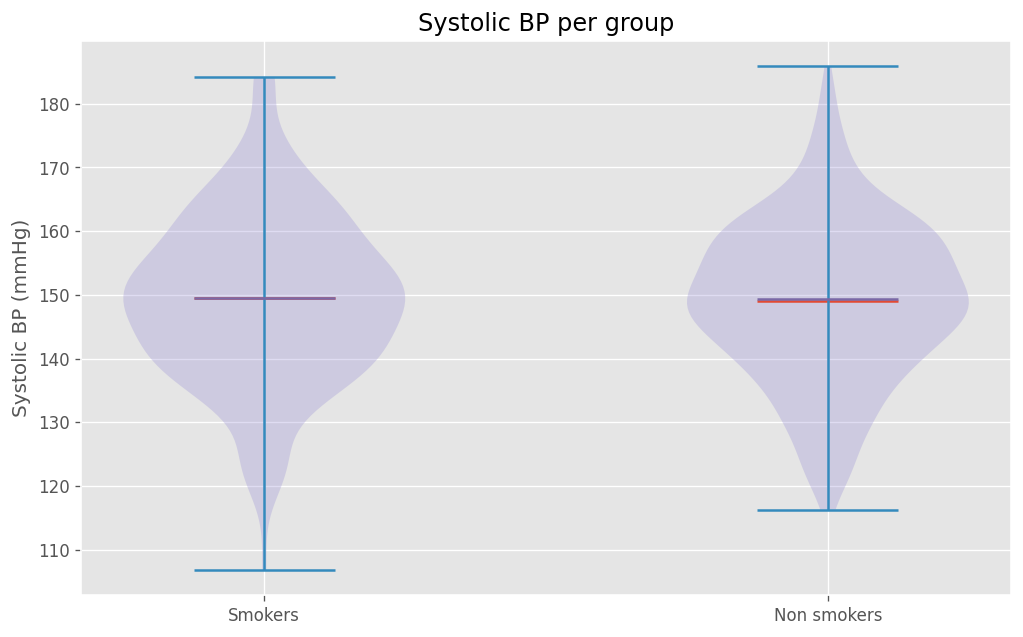

In [8]:
# Violin plot: systoliskt blodtryck efter grupp rökare/icke rökare
data = [smokers, non_smokers]

fig5, ax = plt.subplots()
vp = ax.violinplot(data, showmeans=True, showmedians=True)
for body in vp["bodies"]:
    body.set_facecolor("#988ED5")
vp["cmedians"].set_color("#7A68A6")
vp["cbars"].set_color("#348ABD")
vp["cmaxes"].set_color("#348ABD")
vp["cmins"].set_color("#348ABD")
ax.set_title("Systolic BP per group")
ax.set_ylabel("Systolic BP (mmHg)")
ax.set_xticks([1, 2])
ax.set_xticklabels(["Smokers", "Non smokers"])
fig5.savefig("img/fig5")
plt.show()

## Power

I detta steg undersöker vi hur känsligt vårt t-test är för att upptäcka en verklig skillnad i blodtryck mellan rökare och icke-rökare.  
Poweranalysen kompletterar hypotesprövningen genom att svara på frågan:
**”Skulle vi rimligen ha kunnat upptäcka en effekt om den fanns?”**

Vi beräknar power med tre metoder:

1. **Effektstorlek (Cohen’s d)**  
2. **Teoretisk power** baserat på statistiska antaganden  
3. **Simulerad power** via Monte Carlo-simulering  
4. **Nödvändig effektstorlek** för att uppnå 80% power

**Resultat**:  
Både teoretisk och simulerad styrka beräknades för att jämföra resultaten och kontrollera att simuleringen stämmer med de teoretiska förväntningarna.

Resultaten visar att den statistiska styrkan (power) är mycket låg, cirka **0,11**.  
Detta beror på att den observerade skillnaden i medelvärde (≈ **0,47 mmHg**) är mycket liten jämfört med variationen inom grupperna (SD ≈ **13 mmHg**).

Låg power innebär inte bara att testet misslyckas med att hitta en signifikant skillnad — det innebär också att **testet inte hade rimliga förutsättningar att lyckas**.

En vidare poweranalys visar att det skulle krävas en medelvärdesskillnad på ungefär **2,55 mmHg** för att uppnå **80% power**, vilket är flera gånger större än den observerade skillnaden.

Detta bekräftar att resultatet från hypotesprövningen (icke-signifikant skillnad) är helt i linje med de mycket små effekter som observerats.

**Tolkning**:
I praktiken tyder detta på att rökstatus **inte är förknippad med någon kliniskt eller statistiskt meningsfull förändring av systoliskt blodtryck** i detta urval.

In [14]:
# Power calculations
mathematical_power = theoretical_power(effect["effect size"], n_smokers, n_non_smokers, alpha=0.05)
simulated_power = simulate_ttest_power(smokers_mean, non_smokers_mean, sd_smokers, sd_non_smokers, n_smokers, n_non_smokers, alpha=0.05, n_sim=5000, seed=42)
required_power = power_analysis(n_smokers, n_non_smokers, sd_smokers, sd_non_smokers, diff_means, alpha=0.05, power_target=0.8)

summary2 = pd.DataFrame({
    "Metric": [
        "Cohen's d", "Pooled SD",
        "Theoretical power", "Simulated power",
        "Required mean diff", "Required d"
    ],
    "Value": [
        f"{effect["effect size"]:.3f}", f"{effect["pooled sd"]:.3f}",
        f"{mathematical_power:.3f}", f"{simulated_power["hits"]:.3f}",
        f"{required_power["required mean difference"]:.2f}",
        f"{required_power["required d"]:.3f}"
    ]
})

summary2


    För att uppnå 80.0% power skulle testet kräva en medelvärdesskillnad på cirka 2.55 mmHg (Cohen's d ≈ 0.20). 
    Den observerade skillnaden (≈ 0.47 mmHg) är mycket mindre, vilket förklarar den låga styrkan.
    


,Metric,Value
0,Cohen's d,0.037
1,Pooled SD,12.800
2,Theoretical power,0.118
3,Simulated power,0.106
4,Required mean diff,2.55
5,Required d,0.199


**Källor**:  
*Konfidensintervall*:  
- https://www.youtube.com/watch?v=xjYEYBvPaSc [13/11/2025]  

Scipy-dokumentation angående *ttest_ind*:  
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html [12/11/2025]

Dokumentation från w3cub och statsmodels angående *solve_power*:  
- https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.power.ttestindpower.solve_power [12/11/2025]  
- https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.solve_power.html#statsmodels.stats.power.TTestPower.solve_power [12/11/2025]

## Linjär regression: Prediktion av systoliskt blodtryck

I detta steg använder jag linjär algebra i praktiken för att modellera sambandet mellan systoliskt blodtryck, ålder och vikt. 
Jag använder en enkel linjär regression. 

**Resultat**:  
- Skärning (intercept): 109.50 mmHg  
- Koefficient för ålder: 0.539 mmHg/år  
- Koefficient för vikt: 0.178 mmHg/kg  
- Förklarad varians (R²): 0.405

**Tolkning**:
- En ökning med 10 år i ålder förväntas ge en ökning av blodtrycket med cirka 5.39 mmHg, i genomsnitt.  
- En ökning med 10 kg i vikt förväntas ge en ökning av blodtrycket med cirka 1.78 mmHg, i genomsnitt.  

R²-värdet 0.405 indikerar att modellen förklarar ungefär 40% av variationen i systoliskt blodtryck med hjälp av ålder och vikt.

In [16]:
# Predict systolic blood pressure (SBP) from age and weight
X = df[["age", "weight"]].to_numpy() 
y = df["systolic_bp"].to_numpy() 

# Fit model
model = LinearRegression()
model.fit(X, y)

intercept_hat = float(model.intercept_)
coef_age = float(model.coef_[0])
coef_weight = float(model.coef_[1])

# Predictions and residuals
y_hat = model.predict(X)
residuals = y - y_hat

# Manual R^2
ss_tot = np.sum((y - y.mean())**2)
ss_res = np.sum(residuals**2)
r2 = 1 - ss_res / ss_tot

print(f"""
Skärning (intercept)                 : {intercept_hat: .3f}
Koefficient för ålder (mmHg/år)      : {coef_age: .3f}
Koefficient för vikt (mmHg/kg)       : {coef_weight: .3f}
R^2                                  : {r2: .3f}

Tolkning av koefficienter:
- +10 år => {10 * coef_age:.2f} mmHg högre systoliskt blodtryck (i snitt)
- +10 kg => {10 * coef_weight:.2f} mmHg högre systoliskt blodtryck (i snitt)
""")


Skärning (intercept)                 :  109.499
Koefficient för ålder (mmHg/år)      :  0.539
Koefficient för vikt (mmHg/kg)       :  0.178
R^2                                  :  0.405

Tolkning av koefficienter:
- +10 år => 5.39 mmHg högre systoliskt blodtryck (i snitt)
- +10 kg => 1.78 mmHg högre systoliskt blodtryck (i snitt)



In [ ]:
# PCA (Principal Component Analysis) 
# 
# (Age, Height, Weight, BP, Cholesterol) to discover health-related dimensions

# scale features before


**Utökad analys och visualisering**

- Lägg till minst en ny analys eller graf som ger en djupare förståelse (t.ex. relationen mellan blodtryck och ålder, eller sjukdomsförekomst per kön).



**Dokumentation**

- Skriv docstrings till dina funktioner/klasser.
- Använd markdown-rutor för att förklara vad du gör och varför.



### **För VG ska du även göra:**

- Bygg en mer utvecklad klass som kan hantera flera olika analyser eller visualiseringar.
- Använd en mer avancerad metod (t.ex. multipel regression) eller en extra visualisering som tydligt förklarar resultaten.
- Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.

docstring - https://numpydoc.readthedocs.io/en/latest/format.html